<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#time-monitoring" data-toc-modified-id="time-monitoring-1.0.0.1">time monitoring</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Spark-session" data-toc-modified-id="Spark-session-2">Spark session</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-3">Load data</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Explore-through-Spark-Dataframe-with-'image'-format" data-toc-modified-id="Explore-through-Spark-Dataframe-with-'image'-format-3.0.0.1">Explore through Spark Dataframe with 'image' format</a></span></li><li><span><a href="#We'll-keep-origin-to-get-path-and-extract-label" data-toc-modified-id="We'll-keep-origin-to-get-path-and-extract-label-3.0.0.2">We'll keep origin to get path and extract label</a></span></li><li><span><a href="#Alternate-way-to-deal-with-image" data-toc-modified-id="Alternate-way-to-deal-with-image-3.0.0.3">Alternate way to deal with image</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Use-of-a-CNN-as-feature-extractor" data-toc-modified-id="Use-of-a-CNN-as-feature-extractor-4">Use of a CNN as feature extractor</a></span></li><li><span><a href="#Featurizer" data-toc-modified-id="Featurizer-5">Featurizer</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Define-image-loading-and-featurization-logic-in-a-Pandas-UDF" data-toc-modified-id="Define-image-loading-and-featurization-logic-in-a-Pandas-UDF-5.0.0.1">Define image loading and featurization logic in a Pandas UDF</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Reducer" data-toc-modified-id="Reducer-6">Reducer</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Transform-from-Arrays-into-Vectors-to-perform-reduction" data-toc-modified-id="Transform-from-Arrays-into-Vectors-to-perform-reduction-6.0.0.1">Transform from Arrays into Vectors to perform reduction</a></span></li><li><span><a href="#Initialize-&amp;-Apply-PCA" data-toc-modified-id="Initialize-&amp;-Apply-PCA-6.0.0.2">Initialize &amp; Apply PCA</a></span></li><li><span><a href="#Inverse-transform:-from-Vectors-to-Array---i.e.-Pandas-readability" data-toc-modified-id="Inverse-transform:-from-Vectors-to-Array---i.e.-Pandas-readability-6.0.0.3">Inverse transform: from Vectors to Array - i.e. Pandas readability</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Results-storage" data-toc-modified-id="Results-storage-7">Results storage</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Write-action,-could-be-the-only-action-that-trigger-the-entire-featurizer---reducer-process" data-toc-modified-id="Write-action,-could-be-the-only-action-that-trigger-the-entire-featurizer---reducer-process-7.0.0.1">Write action, could be the only action that trigger the entire featurizer - reducer process</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Introduction

In this notebook, we handle through pySpark, sql & ml, the featurization and the dimension reduction of an image collection.<br/>
Aim is to build a scalable architecture to perform expected transformations, and enable upcoming fast growth of the image collection keeping a viable computationnal time.

In [1]:
# spark
import findspark
findspark.init()
import pyspark
pyspark.__version__

'3.0.1'

In [2]:
# context & session
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [3]:
import pyarrow
pyarrow.__version__

'2.0.0'

In [4]:
# usefull packages
import pandas as pd
import numpy as np
import time
import os
# deal with image
from PIL import Image

In [5]:
# data handling
from pyspark.sql.functions import element_at, split
from pyspark.sql.functions import pandas_udf, PandasUDFType
# from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from typing import Iterator

In [6]:
# ml tasks
from pyspark.ml.image import ImageSchema
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA

In [7]:
# transform
from pyspark.ml.linalg import Vectors, VectorUDT

In [8]:
# core featurizer
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
tf.__version__

'2.4.0'

#### time monitoring

In [9]:
start = time.perf_counter()
stop = time.perf_counter()
print(f'process, elapsed time: {stop - start:0.2f}s')

process, elapsed time: 0.00s


# Spark session

In [10]:
# Initiate a Spark session
spark = SparkSession.builder.master('local[*]').appName('P8').getOrCreate()

In [11]:
# check wether arrow should be enabled by this setting
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [12]:
# open spark UI for app monitoring
spark

# Load data

#### Explore through Spark Dataframe with 'image' format

In [13]:
# define work_path
work_path = '/mnt/c/users/etien/datascience/p8/inputs/applesample/**'

In [14]:
# function to load data into into a spark_df
# with spaces of folder's name removed first, inferschema optional here
start = time.perf_counter()
df_img = spark.read.format('image').load(work_path, inferschema=True) 
stop = time.perf_counter()
print(f'data load with spark.read, elapsed time: {stop - start:0.2f}s')

data load with spark.read, elapsed time: 5.27s


In [15]:
# number of images in this sample
df_img.count()

2134

In [16]:
start = time.perf_counter()
df_img.show(20)
stop = time.perf_counter()
print(f'data load with spark.read, elapsed time: {stop - start:0.2f}s')

+--------------------+
|               image|
+--------------------+
|[file:///mnt/c/us...|
|[file:///mnt/c/us...|
|[file:///mnt/c/us...|
|[file:///mnt/c/us...|
|[file:///mnt/c/us...|
|[file:///mnt/c/us...|
|[file:///mnt/c/us...|
|[file:///mnt/c/us...|
|[file:///mnt/c/us...|
|[file:///mnt/c/us...|
|[file:///mnt/c/us...|
|[file:///mnt/c/us...|
|[file:///mnt/c/us...|
|[file:///mnt/c/us...|
|[file:///mnt/c/us...|
|[file:///mnt/c/us...|
|[file:///mnt/c/us...|
|[file:///mnt/c/us...|
|[file:///mnt/c/us...|
|[file:///mnt/c/us...|
+--------------------+
only showing top 20 rows

data load with spark.read, elapsed time: 1.26s


In [17]:
# display DataFrame schema 
df_img.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [18]:
# origin detail
df_img.select('image.origin').show(1, False, True)

-RECORD 0----------------------------------------------------------------------------------------
 origin | file:///mnt/c/users/etien/datascience/p8/inputs/applesample/Apple_Golden_1/114_100.jpg 
only showing top 1 row



#### We'll keep origin to get path and extract label

In [19]:
# extract label from image.origin
df_img = df_img.withColumn('label', element_at(split(df_img['image.origin'], "/"), -2))

In [20]:
# show first 3 rows with image struct detailed
df_img.select(
    'image.origin',
    'image.height',
    'image.width',
    'image.nChannels',
    'image.mode',
    'image.data',
    'label'
    ).show(1, True)

+--------------------+------+-----+---------+----+--------------------+--------------+
|              origin|height|width|nChannels|mode|                data|         label|
+--------------------+------+-----+---------+----+--------------------+--------------+
|file:///mnt/c/use...|   100|  100|        3|  16|[FF FF FF FF FF F...|Apple_Golden_1|
+--------------------+------+-----+---------+----+--------------------+--------------+
only showing top 1 row



#### Alternate way to deal with image

In [21]:
# use embedded transformer from the binary type to Array, switching to RGB mode
ImageArray_first = ImageSchema.toNDArray(df_img.first()['image'])[:, :, ::-1]

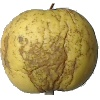

In [22]:
Image.fromarray(ImageArray_first)

In [23]:
# back to the root RDD format to deal with iamges through image structure 
def StructToList(row):
    rowDict = row.asDict()
    FlatArray = ImageSchema.toNDArray(rowDict.get('image'))[:, :, ::-1].ravel().tolist()
    rowDict['FlatArray'] = FlatArray
    return rowDict

In [24]:
# apply function to rdd
df_imgRDD = df_img.rdd.map(StructToList)

In [25]:
# update schema
inputSchema = df_img.schema
newSchema = inputSchema.add('FlatArray', ArrayType(IntegerType()))

In [26]:
# transform back into spark DataFrame
df_imgUpdated = spark.createDataFrame(df_imgRDD, newSchema)

In [27]:
df_imgUpdated.show(5)

+--------------------+--------------+--------------------+
|               image|         label|           FlatArray|
+--------------------+--------------+--------------------+
|[file:///mnt/c/us...|Apple_Golden_1|[255, 255, 255, 2...|
|[file:///mnt/c/us...|Apple_Golden_1|[255, 255, 255, 2...|
|[file:///mnt/c/us...|Apple_Golden_1|[255, 255, 255, 2...|
|[file:///mnt/c/us...|Apple_Golden_1|[255, 255, 255, 2...|
|[file:///mnt/c/us...|Apple_Golden_1|[255, 255, 255, 2...|
+--------------------+--------------+--------------------+
only showing top 5 rows



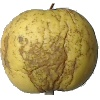

In [28]:
# get back to the image 
New_ImageArray_first = np.array(df_imgUpdated.first()['FlatArray']).reshape(100, 100, 3).astype(np.uint8)
Image.fromarray(New_ImageArray_first)

# Use of a CNN as feature extractor

In [29]:
# model for featurization, last layers truncated.
# nb. spark workers need to access the model and its weights
conv_base = VGG16(
    include_top=False,
    weights=None,
    pooling='max',
    input_shape=(100, 100, 3))

In [30]:
# verify that the top layer is removed
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [31]:
# get weights as broadcasted variable over nodes (provide a copy to each node)
conv_base_weights = spark.sparkContext.broadcast(conv_base.get_weights())

In [32]:
# set weights
# conv_base.set_weights(conv_base_weights.value)

In [33]:
# make conv_base callable
def conv_base_init():
    # returns a VGG 16 model with top layer removed and broadcasted weights
    conv_base = VGG16(
        include_top=False,
        weights=None,
        pooling='max',
        input_shape=(100, 100, 3))
    # error if sparkcontext as it will be called on workers and not only drivers
    # conv_base_weights = sc.broadcast(conv_base.get_weights())
    conv_base.set_weights(conv_base_weights.value)
    return conv_base

# Featurizer

#### Define image loading and featurization logic in a Pandas UDF
This notebook defines the logic in steps, building up to the Pandas UDF. 
The call stack is:
- pandas UDF
    - featurize a pd.Series of images
        - preprocess one image
        
This notebook uses the newer Scalar Iterator pandas UDF to amortize the cost of loading large models on workers.

 In Spark 3.0, Pandas UDFs can accept an iterator of pandas.Series or pandas.DataFrame so that you can load the model only once instead of loading it for every series in the iterator. <br/>
 When the number of images rising over the default 10,000 arrow.maxRecordsPerBatch we expect significant speed ups over a pandas scalar UDF because it iterates through batches of pd.Series.

In [34]:
# function to get tensors from batch path
def gettensorfrompath(image_path):
    path = image_path.replace("file://", "")
    img = load_img(path)
    x = img_to_array(img)
    x = preprocess_input(x)
    return x

In [35]:
# target pandas user defined function to make operation on dataframe with pyspark.sql
@pandas_udf('array<double>')
def featurize(images_data_iter: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
    # load model outside of for loop
    conv_base = conv_base_init()
    for image_data_series in images_data_iter:
        image_path_series = image_data_series['origin']
        # Apply functions to entire series at once
        x = image_path_series.map(gettensorfrompath)
        x = np.stack(list(x.values))
        # option is to enable batch_size
        features = conv_base.predict(x)
        features_flat = [p.flatten() for p in features]
        yield pd.Series(features_flat)

In [36]:
df_img.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- label: string (nullable = true)



In [37]:
# apply featurization
featurized_df = df_img.withColumn('cnn_features', featurize('image')).cache()

In [38]:
start = time.perf_counter()
featurized_df.show()
stop = time.perf_counter()
print(f'data load with spark.read, elapsed time: {stop - start:0.2f}s')

+--------------------+--------------+--------------------+
|               image|         label|        cnn_features|
+--------------------+--------------+--------------------+
|[file:///mnt/c/us...|Apple_Golden_1|[0.85351133346557...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.80916601419448...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.79260116815567...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.80246633291244...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.82079499959945...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.86574697494506...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.83335995674133...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.80765640735626...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.85223478078842...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.81048470735549...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.85044395923614...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.84137392044067...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.85456311702728...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.84026128053665..

In [39]:
featurized_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- label: string (nullable = true)
 |-- cnn_features: array (nullable = true)
 |    |-- element: double (containsNull = true)



In [40]:
# get the number of paritions
print(featurized_df.rdd.getNumPartitions())

67


# Reducer

#### Transform from Arrays into Vectors to perform reduction

In [41]:
# from Array to Vectors for PCA
array_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

In [42]:
vectorized_df = featurized_df.withColumn('cnn_vectors', array_to_vector_udf('cnn_features'))

In [43]:
vectorized_df.show(5, True)

+--------------------+--------------+--------------------+--------------------+
|               image|         label|        cnn_features|         cnn_vectors|
+--------------------+--------------+--------------------+--------------------+
|[file:///mnt/c/us...|Apple_Golden_1|[0.85351133346557...|[0.85351133346557...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.80916601419448...|[0.80916601419448...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.79260116815567...|[0.79260116815567...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.80246633291244...|[0.80246633291244...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.82079499959945...|[0.82079499959945...|
+--------------------+--------------+--------------------+--------------------+
only showing top 5 rows



#### Initialize & Apply PCA
Results may vary with larger dataset, creates an heavy task Action that would affect overall performance.

In [44]:
# reduce with PCA - set k Max to determine the adequate nb of principal components
start = time.perf_counter()
pca = PCA(k=20, inputCol='cnn_vectors', outputCol='pca_vectors')
model = pca.fit(vectorized_df)
stop = time.perf_counter()
print(f'pca - fit best k nb, elapsed time: {stop - start:0.2f}s')

pca - fit best k nb, elapsed time: 204.38s


In [45]:
# apply pca reduction
start = time.perf_counter()
reduced_df = model.transform(vectorized_df)
stop = time.perf_counter()
print(f'pca - application, elapsed time: {stop - start:0.2f}s')

pca - application, elapsed time: 0.18s


In [46]:
reduced_df.show(5, True)

+--------------------+--------------+--------------------+--------------------+--------------------+
|               image|         label|        cnn_features|         cnn_vectors|         pca_vectors|
+--------------------+--------------+--------------------+--------------------+--------------------+
|[file:///mnt/c/us...|Apple_Golden_1|[0.85351133346557...|[0.85351133346557...|[-8.6527770457676...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.80916601419448...|[0.80916601419448...|[-8.6572522956191...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.79260116815567...|[0.79260116815567...|[-8.6280109691146...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.80246633291244...|[0.80246633291244...|[-8.6823958353398...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.82079499959945...|[0.82079499959945...|[-8.6747606035232...|
+--------------------+--------------+--------------------+--------------------+--------------------+
only showing top 5 rows



#### Inverse transform: from Vectors to Array - i.e. Pandas readability

In [47]:
# from Array to Vectors for PCA
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

In [48]:
final_df = reduced_df.withColumn('features', vector_to_array_udf('pca_vectors'))

In [49]:
final_df.show(5, True)

+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
|               image|         label|        cnn_features|         cnn_vectors|         pca_vectors|            features|
+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
|[file:///mnt/c/us...|Apple_Golden_1|[0.85351133346557...|[0.85351133346557...|[-8.6527770457676...|[-8.652777, -0.81...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.80916601419448...|[0.80916601419448...|[-8.6572522956191...|[-8.657252, -0.73...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.79260116815567...|[0.79260116815567...|[-8.6280109691146...|[-8.628011, -0.73...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.80246633291244...|[0.80246633291244...|[-8.6823958353398...|[-8.682396, -0.71...|
|[file:///mnt/c/us...|Apple_Golden_1|[0.82079499959945...|[0.82079499959945...|[-8.6747606035232...|[-8.674761, -0.74...|
+--------------------+--

# Results storage

#### Write action, could be the only action that trigger the entire featurizer - reducer process

In [50]:
# write local results on parquet file
start = time.perf_counter()
final_df.write.mode('overwrite').parquet('/mnt/c/users/etien/datascience/p8/outputs/featurized_sample')
stop = time.perf_counter()
print(f'write local, elapsed time: {stop - start:0.2f}s')

write local, elapsed time: 17.33s


In [51]:
# read local results from parquet file
start = time.perf_counter()
pd_final_df = pd.read_parquet('/mnt/c/users/etien/datascience/p8/outputs/featurized_sample', engine='pyarrow')
stop = time.perf_counter()
print(f'read local, elapsed time: {stop - start:0.2f}s')

read local, elapsed time: 0.96s


In [52]:
# size of the results df
pd_final_df.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2134 entries, 0 to 2133
Columns: 6 entries, image to features
dtypes: object(6)
memory usage: 2.2 MB


In [53]:
# overview
pd_final_df.head(5)

,image,label,cnn_features,cnn_vectors,pca_vectors,features
0,{'origin': 'file:///mnt/c/users/etien/datascie...,Apple_Golden_1,"[0.8535113334655762, 0.4193253815174103, 0.583...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[-8.652777, -0.8131045, 0.80869323, 0.0569087,..."
1,{'origin': 'file:///mnt/c/users/etien/datascie...,Apple_Golden_1,"[0.8091660141944885, 0.37793269753456116, 0.54...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[-8.657252, -0.7366663, 0.7070661, 0.05717787,..."
2,{'origin': 'file:///mnt/c/users/etien/datascie...,Apple_Golden_1,"[0.7926011681556702, 0.3818221986293793, 0.539...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[-8.628011, -0.738455, 0.6893595, 0.059789967,..."
3,{'origin': 'file:///mnt/c/users/etien/datascie...,Apple_Golden_1,"[0.8024663329124451, 0.4175134599208832, 0.570...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[-8.682396, -0.7148256, 0.60340786, 0.08089253..."
4,{'origin': 'file:///mnt/c/users/etien/datascie...,Apple_Golden_1,"[0.8207949995994568, 0.380039781332016, 0.5280...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[-8.674761, -0.74254453, 0.6570486, 0.07146479..."


In [ ]:
spark.stop()